In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Create environment

In [0]:
env = gym.make('CartPole-v0')

In [0]:
gamma = 0.95 # discount rate
learning_rate = 0.01
episodes = 100
epochs = 100
baseline = True # use non-constant baseline or not

In [0]:
state_size = 4
n_actions = env.action_space.n 

# Define the function of the rewards and perform discounting

In [0]:
def discount_reward(r, gamma=0.95, normalization=False):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    
    if normalization:
        mean = np.mean(discounted_r)
        std = np.std(discounted_r)
        discounted_r = (discounted_r - mean) / std
        
    return list(discounted_r)

# Create our Policy Gradient Neural Network model

In [0]:
class Baseline():
    def __init__(self, learning_rate=0.01, state_size=4, name="Baseline"):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,], name='discounted_episodes_rewards_')

            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, 10, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 8, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 1, activation_fn=None, 
                                                                 weights_initializer=tf.contrib.layers.xavier_initializer())

            self.loss = tf.reduce_mean(tf.square(self.fc3 - self.discounted_episodes_rewards_), name="mse")
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [0]:
class PolicyGradient():
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, name='PolicyGradient'):
        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
                self.actions_ = tf.placeholder(tf.int32, [None, action_size], name='actions')
                self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,], name="discounted_episodes_rewards_")

            with tf.name_scope("layers"):
                self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, 64, 
                                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 32, 
                                                             weights_initializer=tf.contrib.layers.xavier_initializer())
            
            with tf.name_scope("flatten"):
                self.flatten = tf.contrib.layers.flatten(self.fc2)
                self.logits = tf.layers.dense(inputs = self.flatten, units = action_size, activation = tf.nn.relu, 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
            
            with tf.name_scope("softmax"):
                self.action_distribution = tf.nn.softmax(self.logits)
            
            with tf.name_scope("loss"):
                self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logits, labels = self.actions_)
                self.loss = tf.reduce_mean(self.neg_log_prob * self.discounted_episodes_rewards_)
                self.learn = tf.train.RMSPropOptimizer(learning_rate).minimize(self.loss)

In [8]:
tf.reset_default_graph()
CartPole = PolicyGradient(name='CartPole', learning_rate=learning_rate, state_size=state_size, action_size=n_actions)
baseline = Baseline(name='Base', learning_rate=learning_rate, state_size=state_size)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Train the agent

In [9]:
# Initialization
env.reset()
all_rewards = []

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    # Each epoch
    for epoch in range(epochs):
        
        # Store action, state and reward
        all_states, all_actions, all_discount_rewards = [], [], []
        running_rewards = []
        
        # Each batch
        for episode in range(episodes):

            state = env.reset()
            episode_rewards = []
            
            while True:            
                # Select action and play that action
                action_probability_distribution = sess.run(CartPole.action_distribution, 
                                                           feed_dict={CartPole.inputs_: state.reshape((1,*state.shape))})
                
                action = np.random.choice(range(action_probability_distribution.shape[1]), p=action_probability_distribution.ravel())  
                new_state, reward, done, _ = env.step(action)
                
                # Record action, state and reward
                all_states.append(state)
                episode_rewards.append(reward)
                
                selected_action = np.zeros(action_probability_distribution.shape[1])
                selected_action[action] = 1
                all_actions.append(selected_action)
                
                # Set current state to new state
                state = new_state
                
                if done:
                    # Discounted reward per episode
                    dis_rewards = discount_reward(episode_rewards)
                    all_discount_rewards += dis_rewards
                    
                    # Total reward per episode
                    running_rewards.append(sum(episode_rewards))
                    break
        
        # Baseline 
        if baseline: 
            original_reward = all_discount_rewards.copy()
            baseline_reward = sess.run(baseline.fc3, feed_dict={baseline.inputs_ : np.vstack(all_states)})
            all_discount_rewards -= np.hstack(baseline_reward)

            _, _= sess.run([baseline.loss, baseline.learn], 
                        feed_dict={baseline.inputs_: np.vstack(all_states),
                        baseline.discounted_episodes_rewards_: original_reward })
         
        # Update policy gradient 
        _, _= sess.run([CartPole.loss, CartPole.learn], 
                                     feed_dict={CartPole.inputs_: np.vstack(all_states),
                                     CartPole.actions_: np.vstack(all_actions),
                                     CartPole.discounted_episodes_rewards_: all_discount_rewards })      
        
        # Average reward per episodes in epoch
        epoch_reward = np.mean(running_rewards)
        all_rewards.append(epoch_reward)
        print('-----------------------------')
        print('epoch ' + str(epoch) + ' finished') 
        print('average reward per episode in epoch:',epoch_reward)
        
        # Early stopping
        if epoch_reward >= 200:
            break

-----------------------------
epoch 0 finished
average reward per episode in epoch: 23.08
-----------------------------
epoch 1 finished
average reward per episode in epoch: 24.45
-----------------------------
epoch 2 finished
average reward per episode in epoch: 25.47
-----------------------------
epoch 3 finished
average reward per episode in epoch: 25.0
-----------------------------
epoch 4 finished
average reward per episode in epoch: 23.33
-----------------------------
epoch 5 finished
average reward per episode in epoch: 24.22
-----------------------------
epoch 6 finished
average reward per episode in epoch: 24.13
-----------------------------
epoch 7 finished
average reward per episode in epoch: 24.78
-----------------------------
epoch 8 finished
average reward per episode in epoch: 22.89
-----------------------------
epoch 9 finished
average reward per episode in epoch: 24.76
-----------------------------
epoch 10 finished
average reward per episode in epoch: 24.87
----------

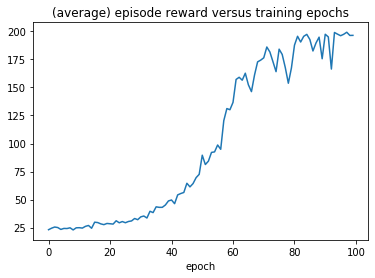

In [12]:
plt.plot(all_rewards)
plt.title('(average) episode reward versus training epochs')
plt.xlabel('epoch')
plt.show()